In [1]:
from rasterio.plot import show
from rasterio.merge import merge
import rasterio as rio
from rasterio import features
import rioxarray

from pathlib import Path
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from PIL import Image

Zwischenspeichern des Raster Stacks auf der Festplatte. <br>
Da alle Raster-Dateien des Arbeitsgebietes die gleiche Ausdehnung haben, können sie einfach mit rasterio aufeinandergestackt werden.

In [2]:

def make_stack (path, file_string, appendix):
    #getall file paths from path
    #path = 'C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/'
    #file_string = "ND"
    file_list = glob.glob(path + file_string+'*.tiff')
    str_start = -13
    str_end = -5

    # Read metadata of first file
    with rio.open(file_list[0]) as src0:
        meta = src0.meta
        # mein Proj4 Pfad ist kaputt, deshalb hier der explizite Proj4 String
        meta.update({'crs': 'PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],AUTHORITY["EPSG","25832"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'})

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rio.open(path + 'stack_' +appendix + '.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
            with rio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
                time = pd.to_datetime(layer[str_start:str_end], format='%Y%m%d')
                # speichere Zeitstempel in Band descriptions
                dst.set_band_description(id, str(time))


In [3]:
def reclassify(input_ds):
    for i in range(len(input_ds)):
        arr = input_ds[i].values
        arr[np.where(arr< 5)] = 0
        arr[np.where((arr> 5) & (arr <= 25))] = 1
        arr[np.where((arr> 25) & (arr <= 45))] = 2
        arr[np.where((arr> 45) & (arr <= 65))] = 3
        arr[np.where((arr> 65) & (arr <= 85))] = 4
        arr[np.where(arr> 85)] = 5
        input_ds[i] = arr
    return input_ds

In [4]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/', 'ND', 'NDVI')

In [5]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDWI_20m_arbeitsgebiete/Thueringen/', 'ND', 'NDWI')

In [6]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/', 'SCL', 'SCL')

In [7]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Unterfranken/', 'ND', 'NDVI')

In [8]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDWI_20m_arbeitsgebiete/Unterfranken/', 'ND', 'NDWI')

In [9]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Unterfranken/', 'SCL', 'SCL')

In [10]:
ndvi_thueringen = rioxarray.open_rasterio('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/stack_NDVI.tif')
ndwi_thueringen = rioxarray.open_rasterio('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDWI_20m_arbeitsgebiete/Thueringen/stack_NDWI.tif')
SCL_thueringen = rioxarray.open_rasterio('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/stack_SCL.tif')

ndvi_thueringen = ndvi_thueringen.assign_coords({"band": (pd.to_datetime(list(ndvi_thueringen.long_name)))})
ndwi_thueringen = ndwi_thueringen.assign_coords({"band": (pd.to_datetime(list(ndwi_thueringen.long_name)))})
SCL_thueringen = SCL_thueringen.assign_coords({"band": (pd.to_datetime(list(SCL_thueringen.long_name)))})

ndvi_thueringen.attrs['_FillValue'] = np.nan
ndwi_thueringen.attrs['_FillValue'] = np.nan

ndvi_thueringen.attrs['long_name'] = None
ndwi_thueringen.attrs['long_name'] = None
SCL_thueringen.attrs['long_name'] = None

Das einzige, was bei dem oberen Datensatz nicht so schön ist, ist dass immer alle time stamps aus dem Attribut "long_name" angezeigt werden.
Ich hatte versucht, mit assin_coords() den einzelnen Arrays eine "time" zuzuordnen, aber das hat nur einmal funktioniert und dann wurde es einfach nicht mehr im xarray gespeichert...
Zur Not kann man aber immer die Position des bands im Stack mit der Position in dem long_name array gleichsetzen.

In [11]:
is_cloud = xr.where(((SCL_thueringen == 0) | 
                 (SCL_thueringen == 1) | 
                 (SCL_thueringen == 3) | 
                 (SCL_thueringen == 8) | 
                 (SCL_thueringen == 9) | 
                 (SCL_thueringen == 10) | 
                 (SCL_thueringen == 11) |
                 (SCL_thueringen == 255)), True, False)

#mask only cloud free
mask = xr.where((is_cloud == 0), True, False)
ndvi_thueringen = ndvi_thueringen.where(mask, np.nan)
ndwi_thueringen = ndwi_thueringen.where(mask, np.nan)

In [12]:
valid_obs_per_year = mask.resample(band='1Y').sum(dim='band')

### Pfad unten anpassen mit Staunässe shapefile

In [12]:
geodf = gpd.read_file(r'C:\Uni Jena\GEO 411\Data\Feldgrenzen\thueringen_stauenaesse_bekannt.shp')
trocken = gpd.read_file(r'C:\Uni Jena\GEO 411\Data\Feldgrenzen\vergleichsfelder.shp')

In [13]:
#get geometries of waterlogged fields
geodf = geodf[geodf['cat']=='staunaesse']
geodf = geodf.set_crs('epsg:25832', allow_override=True)
trocken = trocken.set_crs('epsg:25832', allow_override=True)

In [15]:
stau0 = geodf[geodf['field_id']==0].geometry
stau1 = geodf[geodf['field_id']==1].geometry
stau2 = geodf[geodf['field_id']==2].geometry
stau3 = geodf[geodf['field_id']==3].geometry
stau4 = geodf[geodf['field_id']==4].geometry
stau5 = geodf[geodf['field_id']==5].geometry
stau6 = geodf[geodf['field_id']==6].geometry

liste_stau = [stau0, stau1, stau2, stau3, stau4, stau5, stau6]

trock0 = trocken[trocken.index==0].geometry
trock1 = trocken[trocken.index==1].geometry
trock2 = trocken[trocken.index==2].geometry
trock3 = trocken[trocken.index==3].geometry
trock4 = trocken[trocken.index==4].geometry
trock5 = trocken[trocken.index==5].geometry
trock6 = trocken[trocken.index==6].geometry
trock7 = trocken[trocken.index==7].geometry

liste_trock = [trock0, trock1, trock2, trock3, trock4, trock5, trock6, trock7]

<Axes: >

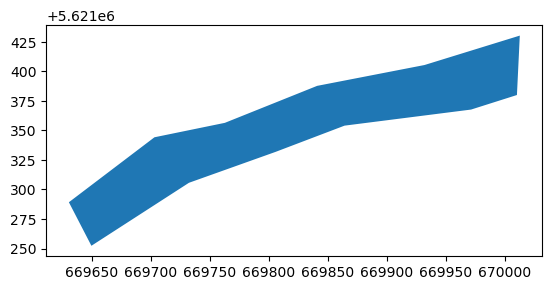

In [16]:
liste_stau[1].plot()

<Axes: >

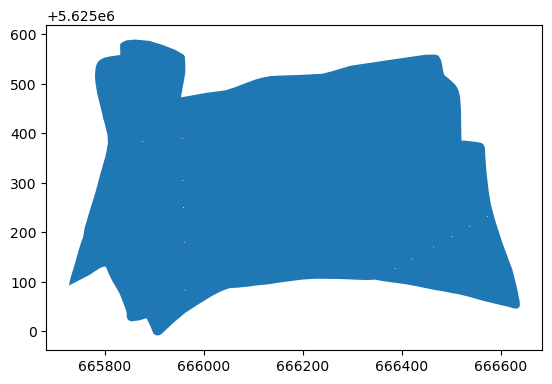

In [17]:
liste_trock[1].plot()

In [14]:
staux = geodf.geometry
trockx = trocken.geometry

In [19]:
#staux.to_file(r'C:\Uni Jena\GEO 411\plots\Sentinel_Karten\thueringen_staunaesse_reproj.shp')

In [20]:
liste_stau_ndwi = []
liste_stau_ndvi = []
for i in range (len(liste_stau)):
    res = ndwi_thueringen.rio.clip(liste_stau[i], all_touched=True)
    liste_stau_ndwi.append(res)
    res1 = ndvi_thueringen.rio.clip(liste_stau[i], all_touched=True)
    liste_stau_ndvi.append(res1)

In [21]:
liste_trock_ndwi = []
liste_trock_ndvi = []
for i in range (len(liste_trock)):
    res = ndwi_thueringen.rio.clip(liste_trock[i], all_touched=True)
    liste_trock_ndwi.append(res)
    res1 = ndvi_thueringen.rio.clip(liste_trock[i], all_touched=True)
    liste_trock_ndvi.append(res1)

In [37]:
print(np.unique(liste_stau_ndwi[0], return_counts=True)[0][:20])
print(np.unique(liste_stau_ndvi[0], return_counts=True)[0][:20])

print(np.unique(liste_trock_ndwi[0], return_counts=True)[0][:20])
print(np.unique(liste_trock_ndvi[0], return_counts=True)[0][:20])

[-0.6658416  -0.6644622  -0.6559356  -0.65491587 -0.6488472  -0.6442532
 -0.6422703  -0.64081424 -0.6408121  -0.6402798  -0.63920385 -0.63920164
 -0.6387712  -0.6377171  -0.6369404  -0.63692534 -0.63607025 -0.6353004
 -0.63444823 -0.6270214 ]
[-0.06855278 -0.03258356 -0.02264906 -0.01448838 -0.01213513 -0.0015674
  0.00315325  0.00387297  0.00900901  0.01026444  0.01376743  0.01401186
  0.01626988  0.01642382  0.01742613  0.01845018  0.01860687  0.02162044
  0.02163808  0.02212478]
[-0.7060051  -0.69493866 -0.6887912  -0.68773735 -0.6807596  -0.6780735
 -0.6682742  -0.66116685 -0.6539337  -0.6531165  -0.6513393  -0.6506338
 -0.6474398  -0.6466587  -0.64455956 -0.64439195 -0.6404701  -0.6378883
 -0.6350549  -0.6344239 ]
[-0.16903006 -0.1507552  -0.13282356 -0.12770745 -0.11687161 -0.11315909
 -0.11153626 -0.09444445 -0.09023202 -0.08869395 -0.08670348 -0.08360974
 -0.08354289 -0.07746639 -0.07417037 -0.06526668 -0.05971155 -0.05803093
 -0.05349713 -0.05137913]


In [44]:
liste_trock_ndwi[0][9]

<xarray.DataArray (y: 22, x: 31)>
array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan, -0.27804065,         nan, -0.25698757, -0.2785426 ,
        -0.3175853 ,         nan,         nan, -0.39115986,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan, -0.22173351,         nan, -0.31138977,         nan,
        -0.38183886,         nan,         nan,         nan, -0.37307692,
                nan,         nan,         nan,         nan,         nan,
...
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan, -0.2648305 , -0.25057766, -0.2644125 ,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan]], dtype=float32)
Coordinates:
    band         datetime64[ns] 2017-05-17
  * x            (x) float64 6.698e+05 6.698e+05 ... 6.704e+05 6.704e+05
  * y            (y) float64 5.626e+06 5.626e+06 ... 5.625e+06 5.625e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      None
    _FillValue:     nan

In [45]:
liste_trock_ndvi[0][9]

<xarray.DataArray (y: 22, x: 31)>
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan, 0.2808926 ,        nan, 0.2924428 , 0.3128659 ,
        0.33235034,        nan,        nan, 0.3769737 ,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan, 0.17345925,        nan, 0.33050624,        nan,
        0.4884433 ,        nan,        nan,        nan, 0.4363974 ,
               nan,        nan,        nan,        nan,        nan,
...
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.37537798, 0.3405807 , 0.3369863 ,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    band         datetime64[ns] 2017-05-17
  * x            (x) float64 6.698e+05 6.698e+05 ... 6.704e+05 6.704e+05
  * y            (y) float64 5.626e+06 5.626e+06 ... 5.625e+06 5.625e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      None
    _FillValue:     nan

In [48]:
for i in range(len(liste_stau_ndwi)):
    liste_stau_ndwi[i].rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped"+str(i)+"_stau_ndwi.tiff")
    liste_stau_ndvi[i].rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped"+str(i)+"_stau_ndvi.tiff")

In [49]:
for i in range(len(liste_trock_ndwi)):
    liste_trock_ndwi[i].rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped"+str(i)+"_trock_ndwi.tiff")
    liste_trock_ndvi[i].rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped"+str(i)+"_trock_ndvi.tiff")

In [15]:
clipped_ndvi = ndvi_thueringen.rio.clip(staux, all_touched=True)
clipped_ndwi = ndwi_thueringen.rio.clip(staux, all_touched=True)

mask_clip = mask.rio.clip(staux, all_touched=True)

clipped_ndvi = clipped_ndvi.where(mask_clip, np.nan)
clipped_ndwi = clipped_ndwi.where(mask_clip, np.nan)

In [16]:
clipped_ndvi.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped_staunass_ndvi.tiff")
clipped_ndwi.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped_staunass_ndwi.tiff")

In [17]:
clipped_ndvi_trocken = ndvi_thueringen.rio.clip(trockx, all_touched=True)
clipped_ndwi_trocken = ndwi_thueringen.rio.clip(trockx, all_touched=True)

mask_trocken = mask.rio.clip(trockx, all_touched=True)

clipped_ndvi_trocken = clipped_ndvi_trocken.where(mask_trocken, np.nan)
clipped_ndwi_trocken = clipped_ndwi_trocken.where(mask_trocken, np.nan)

In [18]:
clipped_ndvi_trocken.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped_trocken_ndvi.tiff")
clipped_ndwi_trocken.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped_trocken_ndwi.tiff")

## Hier sollte ein Boxplot erstellt werden
- für jeden Array einen: clipped0, clipped1 ... clipped0_ndvi ... 
- clipped_ndwi und clipped_ndvi sind ein subset über alle Polygone mit Staunässe
- xr.resample ist eine gute Methode um Zeiträume zusammenzufassen z.B. res = sample.resample(time='1Y').mean(dim='time')
- mit der resample mthode kannst du auch "4Y" für den gesamten Zeitraum einstellen
-Auf diesem zweidimensionalen Array lässt sich ein Boxp,lot erstellen und andere Parameter ableiten

In [19]:
#read data if alread y creatred above
staunass_ndvi = rioxarray.open_rasterio("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped_staunass_ndvi.tiff").assign_coords({"band": ndvi_thueringen.band})
staunass_ndwi = rioxarray.open_rasterio("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped_staunass_ndwi.tiff").assign_coords({"band": ndwi_thueringen.band})

trocken_ndvi = rioxarray.open_rasterio("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped_trocken_ndvi.tiff").assign_coords({"band": ndvi_thueringen.band})
trocken_ndwi = rioxarray.open_rasterio("C:/Uni Jena/GEO 411/Data/Sentinel-2/Boxplots/clipped_trocken_ndwi.tiff").assign_coords({"band": ndwi_thueringen.band})

In [20]:
#staunass_ndvi = staunass_ndvi.where(((staunass_ndvi['band.month'] >=3) & (staunass_ndvi['band.month'] <= 6)), drop=True)
#staunass_ndwi = staunass_ndwi.where(((staunass_ndwi['band.month'] >=3) & (staunass_ndwi['band.month'] <= 6)), drop=True)

#trocken_ndvi = trocken_ndvi.where(((trocken_ndvi['band.month'] >=3) & (trocken_ndvi['band.month'] <= 6)), drop=True)
#trocken_ndwi = trocken_ndwi.where(((trocken_ndwi['band.month'] >=3) & (trocken_ndwi['band.month'] <= 6)), drop=True)

In [21]:
path = r'C:\Uni Jena\GEO 411\Data\Sentinel-2\Boxplots\\'
sndvi_list = glob.glob(path+ '*_stau_ndvi*.tiff')
tndvi_list = glob.glob(path+ '*_trock_ndvi*.tiff')
sndwi_list = glob.glob(path+ '*_stau_ndwi*.tiff')
tndwi_list = glob.glob(path+ '*_trock_ndwi*.tiff')

In [22]:
tndwi_list

['C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped0_trock_ndwi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped1_trock_ndwi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped2_trock_ndwi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped3_trock_ndwi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped4_trock_ndwi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped5_trock_ndwi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped6_trock_ndwi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped7_trock_ndwi.tiff']

In [23]:
tndvi_list

['C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped0_trock_ndvi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped1_trock_ndvi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped2_trock_ndvi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped3_trock_ndvi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped4_trock_ndvi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped5_trock_ndvi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped6_trock_ndvi.tiff',
 'C:\\Uni Jena\\GEO 411\\Data\\Sentinel-2\\Boxplots\\clipped7_trock_ndvi.tiff']

In [24]:
liste_stau_ndwi = [rioxarray.open_rasterio(i).assign_coords({"band": ndwi_thueringen.band}) for i in sndwi_list]
liste_stau_ndvi = [rioxarray.open_rasterio(i).assign_coords({"band": ndvi_thueringen.band}) for i in sndvi_list]
liste_trock_ndwi = [rioxarray.open_rasterio(i).assign_coords({"band": ndwi_thueringen.band}) for i in tndwi_list]
liste_trock_ndvi = [rioxarray.open_rasterio(i).assign_coords({"band": ndvi_thueringen.band}) for i in tndvi_list]

<Axes: >

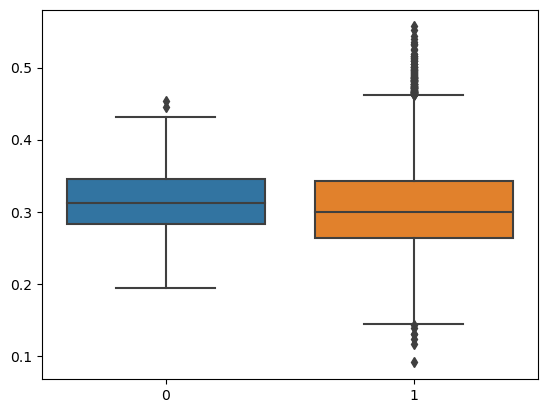

In [25]:
import seaborn as sb

#ndvi mean
sb.boxplot([staunass_ndvi.mean(dim="band").values, trocken_ndvi.mean(dim="band").values])

In [26]:
print(np.unique(liste_stau_ndwi[0], return_counts=True)[0][:20])
print(np.unique(liste_stau_ndvi[0], return_counts=True)[0][:20])
print(np.unique(liste_trock_ndwi[0], return_counts=True)[0][:20])
print(np.unique(liste_trock_ndvi[0], return_counts=True)[0][:20])

[-0.6658416  -0.6644622  -0.6559356  -0.65491587 -0.6488472  -0.6442532
 -0.6422703  -0.64081424 -0.6408121  -0.6402798  -0.63920385 -0.63920164
 -0.6387712  -0.6377171  -0.6369404  -0.63692534 -0.63607025 -0.6353004
 -0.63444823 -0.6270214 ]
[-0.06855278 -0.03258356 -0.02264906 -0.01448838 -0.01213513 -0.0015674
  0.00315325  0.00387297  0.00900901  0.01026444  0.01376743  0.01401186
  0.01626988  0.01642382  0.01742613  0.01845018  0.01860687  0.02162044
  0.02163808  0.02212478]
[-0.7060051  -0.69493866 -0.6887912  -0.68773735 -0.6807596  -0.6780735
 -0.6682742  -0.66116685 -0.6539337  -0.6531165  -0.6513393  -0.6506338
 -0.6474398  -0.6466587  -0.64455956 -0.64439195 -0.6404701  -0.6378883
 -0.6350549  -0.6344239 ]
[-0.16903006 -0.1507552  -0.13282356 -0.12770745 -0.11687161 -0.11315909
 -0.11153626 -0.09444445 -0.09023202 -0.08869395 -0.08670348 -0.08360974
 -0.08354289 -0.07746639 -0.07417037 -0.06526668 -0.05971155 -0.05803093
 -0.05349713 -0.05137913]


In [27]:
# Funktionen zur Erstellung von Boxplotdaten pro Feld für die einzelnen Lagemaße


def get_mean_data(data):

    boxplot_data = data.mean(dim=("band"))

    return boxplot_data.to_numpy()


def get_median_data(data):

    boxplot_data = data.median(dim=("band"))

    return boxplot_data.to_numpy()


def get_25_percentile_data(data):

    boxplot_data = data.quantile(q=0.25, dim=("band"))

    return boxplot_data.to_numpy()


def get_75_percentile_data(data):

    boxplot_data = data.quantile(q=0.75, dim=("band"))

    return boxplot_data.to_numpy()

In [28]:
# Einzelne Felddaten

gesamt_list_ndvi = [staunass_ndvi, trocken_ndvi]
gesamt_list_ndwi = [staunass_ndwi, trocken_ndwi]

mean_trock_list = []
median_trock_list = []
quantil_25_trock_list = []
quantil_75_trock_list = []

mean_stau_list = []
median_stau_list = []
quantil_25_stau_list = []
quantil_75_stau_list = []

mean_trock_list_ndvi = []
median_trock_list_ndvi = []
quantil_25_trock_list_ndvi = []
quantil_75_trock_list_ndvi = []

mean_stau_list_ndvi = []
median_stau_list_ndvi = []
quantil_25_stau_list_ndvi = []
quantil_75_stau_list_ndvi = []


########################################
mean_gesamt_list_ndvi = []
median_gesamt_list_ndvi = []
quantil_25_gesamt_list_ndvi = []
quantil_75_gesamt_list_ndvi = []

mean_gesamt_list_ndwi = []
median_gesamt_list_ndwi = []
quantil_25_gesamt_list_ndwi = []
quantil_75_gesamt_list_ndwi = []


for field in liste_stau_ndwi:

    # Mean
    field_mean = get_mean_data(field)
    mean_stau_list.append(field_mean)


    # Median
    field_median = get_median_data(field)
    median_stau_list.append(field_median)


    # percentile 5
    field_quant_25 = get_25_percentile_data(field)
    quantil_25_stau_list.append(field_quant_25)


    # percentile 75
    field_quant_75 = get_75_percentile_data(field)
    quantil_75_stau_list.append(field_quant_75)
    

for field in liste_trock_ndwi:

    # Mean
    field_mean = get_mean_data(field)
    mean_trock_list.append(field_mean)


    # Median
    field_median = get_median_data(field)
    median_trock_list.append(field_median)


    # percentile 5
    field_quant_25 = get_25_percentile_data(field)
    quantil_25_trock_list.append(field_quant_25)


    # percentile 75
    field_quant_75 = get_75_percentile_data(field)
    quantil_75_trock_list.append(field_quant_75)
    

for field in liste_stau_ndvi:

    # Mean
    field_mean = get_mean_data(field)
    mean_stau_list_ndvi.append(field_mean)


    # Median
    field_median = get_median_data(field)
    median_stau_list_ndvi.append(field_median)


    # percentile 5
    field_quant_25 = get_25_percentile_data(field)
    quantil_25_stau_list_ndvi.append(field_quant_25)


    # percentile 75
    field_quant_75 = get_75_percentile_data(field)
    quantil_75_stau_list_ndvi.append(field_quant_75)
    

for field in liste_trock_ndvi:

    # Mean
    field_mean = get_mean_data(field)
    mean_trock_list_ndvi.append(field_mean)


    # Median
    field_median = get_median_data(field)
    median_trock_list_ndvi.append(field_median)


    # percentile 5
    field_quant_25 = get_25_percentile_data(field)
    quantil_25_trock_list_ndvi.append(field_quant_25)


    # percentile 75
    field_quant_75 = get_75_percentile_data(field)
    quantil_75_trock_list_ndvi.append(field_quant_75)
    
    
for field in gesamt_list_ndvi:

    # Mean
    field_mean = get_mean_data(field)
    mean_gesamt_list_ndvi.append(field_mean)


    # Median
    field_median = get_median_data(field)
    median_gesamt_list_ndvi.append(field_median)


    # percentile 5
    field_quant_25 = get_25_percentile_data(field)
    quantil_25_gesamt_list_ndvi.append(field_quant_25)


    # percentile 75
    field_quant_75 = get_75_percentile_data(field)
    quantil_75_gesamt_list_ndvi.append(field_quant_75)
    
    
for field in gesamt_list_ndwi:

    # Mean
    field_mean = get_mean_data(field)
    mean_gesamt_list_ndwi.append(field_mean)


    # Median
    field_median = get_median_data(field)
    median_gesamt_list_ndwi.append(field_median)


    # percentile 5
    field_quant_25 = get_25_percentile_data(field)
    quantil_25_gesamt_list_ndwi.append(field_quant_25)


    # percentile 75
    field_quant_75 = get_75_percentile_data(field)
    quantil_75_gesamt_list_ndwi.append(field_quant_75)

C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-pac

In [29]:
#sb.boxplot(array_data)
# sb.boxplot(mean_field_list)

[Text(0, 0.5, 'mean NDVI'), [Text(0, 0, 'staunass'), Text(1, 0, 'trocken')]]

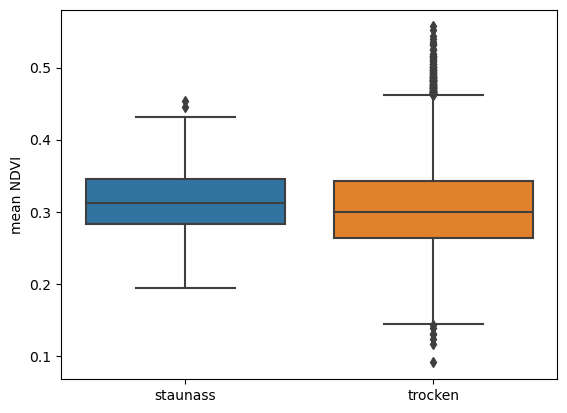

In [30]:
sb.boxplot(mean_gesamt_list_ndvi).set( 
    ylabel='mean NDVI',
    xticklabels=['staunass','trocken'])

[Text(0, 0.5, 'mean NDWI'), [Text(0, 0, 'staunass'), Text(1, 0, 'trocken')]]

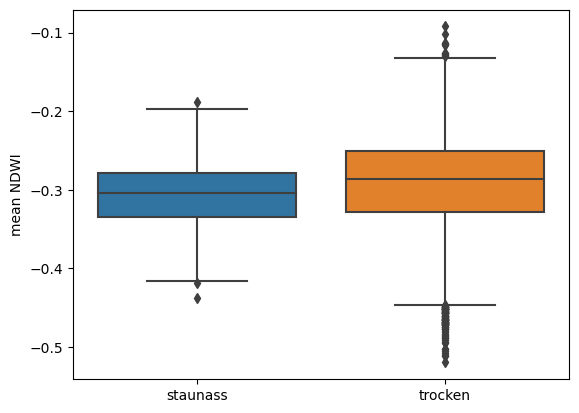

In [31]:
sb.boxplot(mean_gesamt_list_ndwi).set( 
    ylabel='mean NDWI',
    xticklabels=['staunass','trocken'])

[Text(0, 0.5, 'median NDWI'), [Text(0, 0, 'staunass'), Text(1, 0, 'trocken')]]

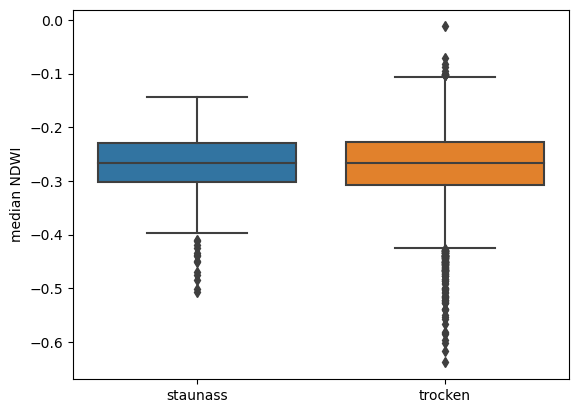

In [32]:
sb.boxplot(median_gesamt_list_ndwi).set( 
    ylabel='median NDWI',
    xticklabels=['staunass','trocken'])

[Text(0, 0.5, 'median NDVI'), [Text(0, 0, 'staunass'), Text(1, 0, 'trocken')]]

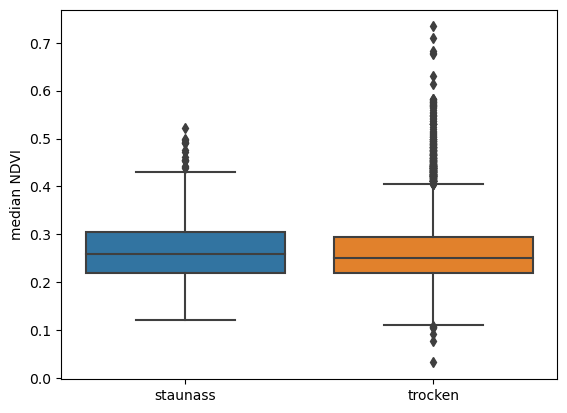

In [33]:
sb.boxplot(median_gesamt_list_ndvi).set( 
    ylabel='median NDVI',
    xticklabels=['staunass','trocken'])

[Text(0, 0.5, 'quantile 25 NDWI'),
 [Text(0, 0, 'staunass'), Text(1, 0, 'trocken')]]

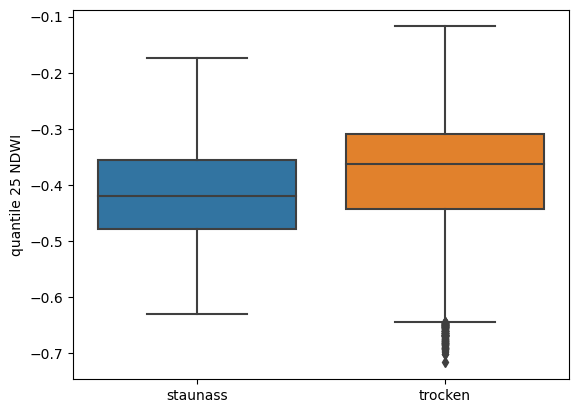

In [34]:
sb.boxplot(quantil_25_gesamt_list_ndwi).set( 
    ylabel='quantile 25 NDWI',
    xticklabels=['staunass','trocken'])

[Text(0, 0.5, 'quantile 25 NDVI'),
 [Text(0, 0, 'staunass'), Text(1, 0, 'trocken')]]

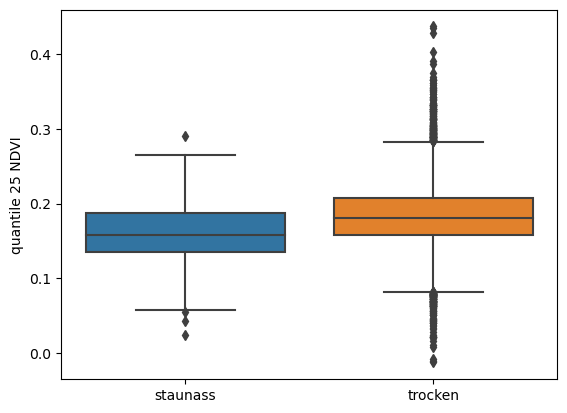

In [35]:
sb.boxplot(quantil_25_gesamt_list_ndvi).set( 
    ylabel='quantile 25 NDVI',
    xticklabels=['staunass','trocken'])

[Text(0, 0.5, 'quantile 75 NDWI'),
 [Text(0, 0, 'staunass'), Text(1, 0, 'trocken')]]

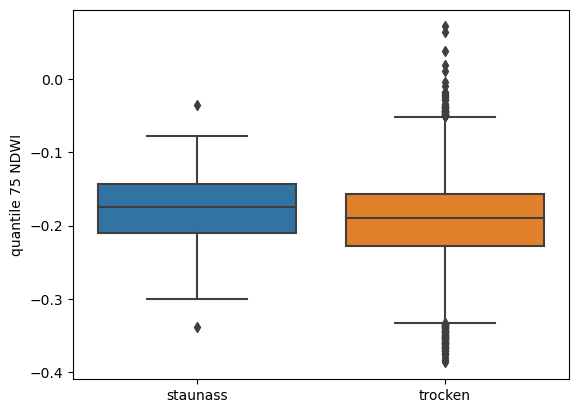

In [36]:
sb.boxplot(quantil_75_gesamt_list_ndwi).set( 
    ylabel='quantile 75 NDWI',
    xticklabels=['staunass','trocken'])

[Text(0, 0.5, 'quantile 75 NDVI'),
 [Text(0, 0, 'staunass'), Text(1, 0, 'trocken')]]

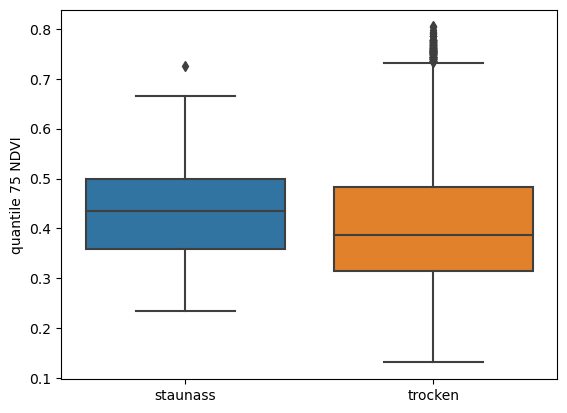

In [37]:
sb.boxplot(quantil_75_gesamt_list_ndvi).set( 
    ylabel='quantile 75 NDVI',
    xticklabels=['staunass','trocken'])

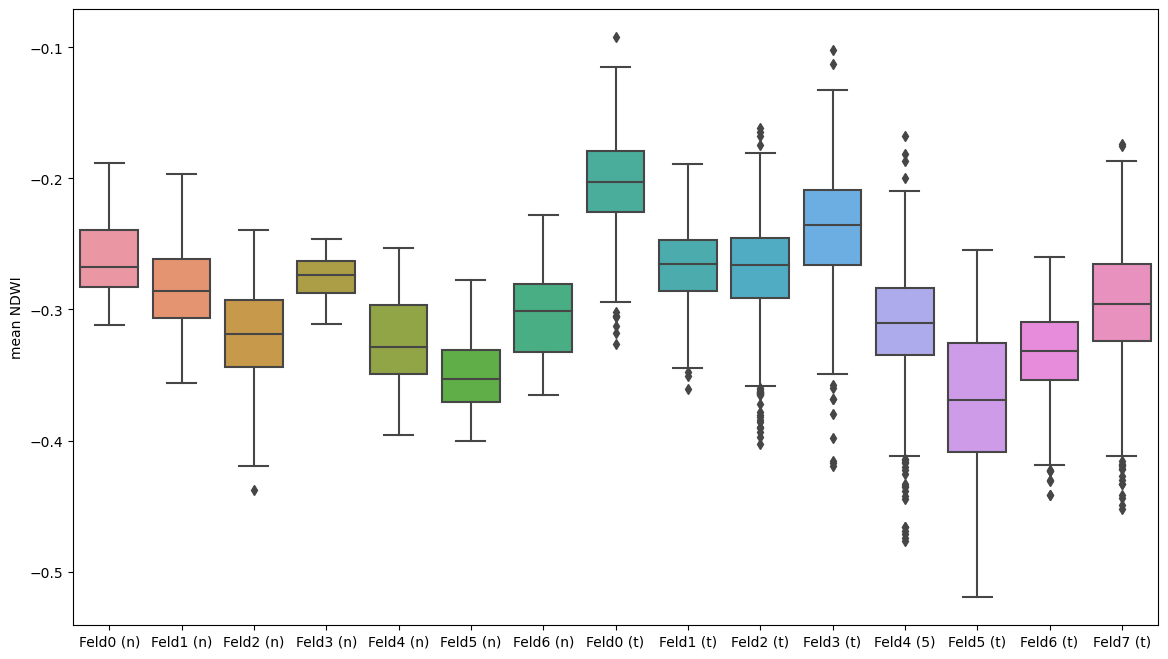

In [49]:
plt.figure(figsize=(14, 8))

sb.boxplot(mean_stau_list+mean_trock_list).set( 
    ylabel='mean NDWI',
    xticklabels=['Feld0 (n)','Feld1 (n)', 'Feld2 (n)','Feld3 (n)', 'Feld4 (n)','Feld5 (n)', 
                 'Feld6 (n)','Feld0 (t)', 'Feld1 (t)','Feld2 (t)', 'Feld3 (t)','Feld4 (5)', 
                 'Feld5 (t)','Feld6 (t)', 'Feld7 (t)'])


plt.show()

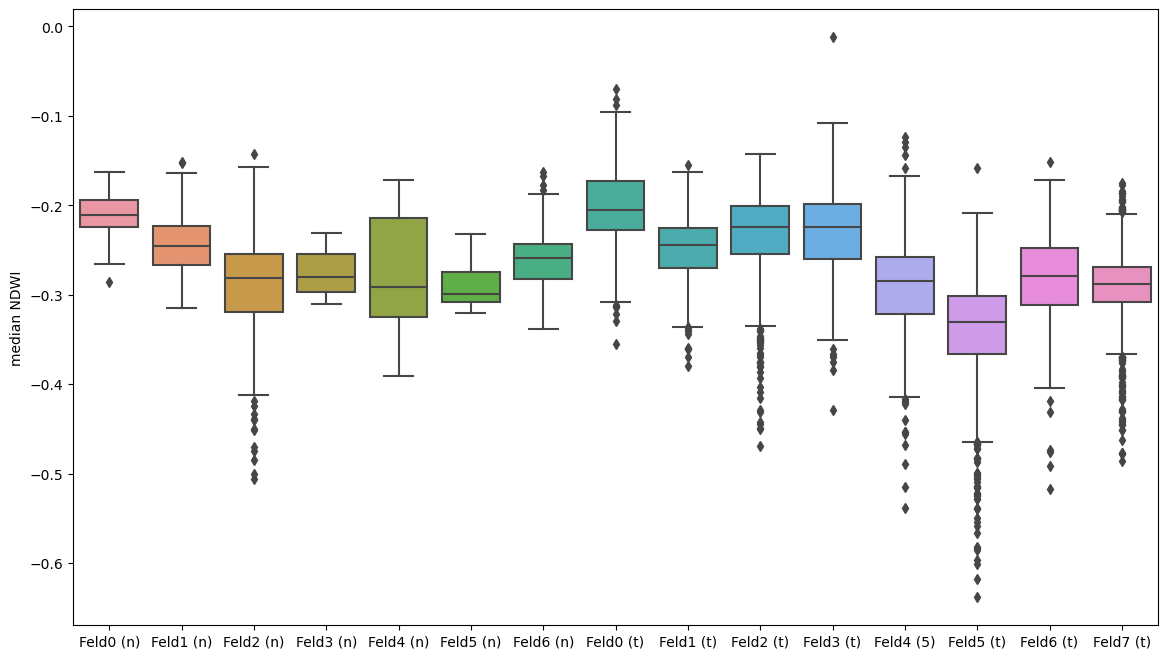

In [39]:
plt.figure(figsize=(14, 8))
sb.boxplot(median_stau_list+median_trock_list).set( 
    ylabel='median NDWI',
    xticklabels=['Feld0 (n)','Feld1 (n)', 'Feld2 (n)','Feld3 (n)', 'Feld4 (n)','Feld5 (n)', 
                 'Feld6 (n)','Feld0 (t)', 'Feld1 (t)','Feld2 (t)', 'Feld3 (t)','Feld4 (5)', 
                 'Feld5 (t)','Feld6 (t)', 'Feld7 (t)'])


plt.show()

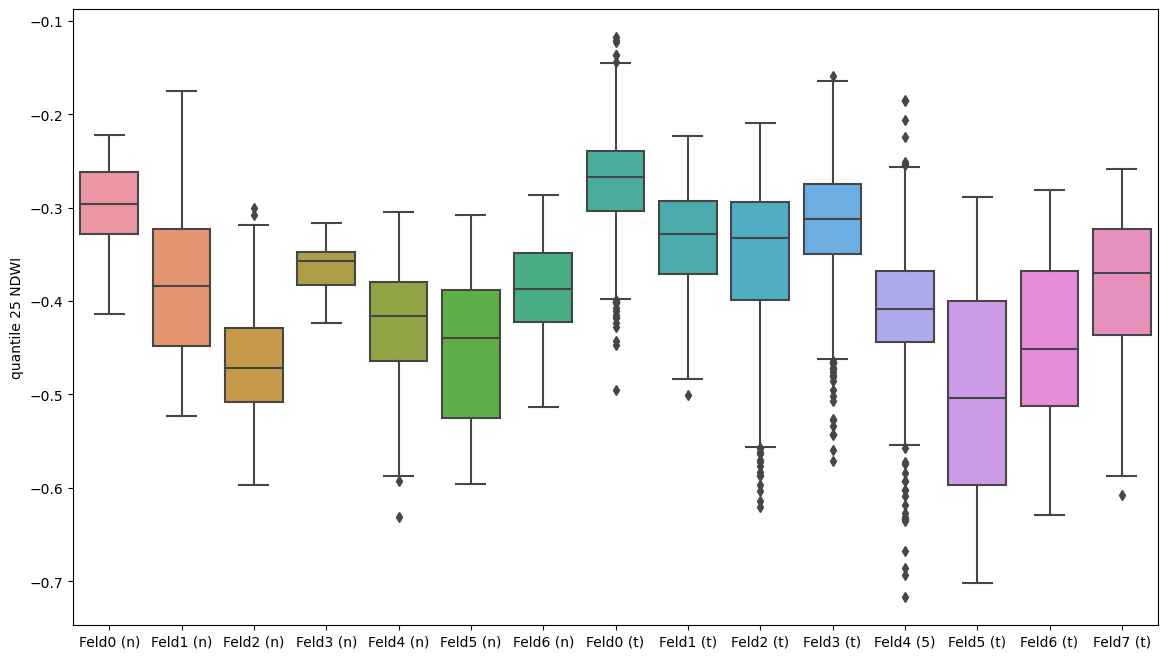

In [40]:
plt.figure(figsize=(14, 8))
sb.boxplot(quantil_25_stau_list+quantil_25_trock_list).set( 
    ylabel='quantile 25 NDWI',
    xticklabels=['Feld0 (n)','Feld1 (n)', 'Feld2 (n)','Feld3 (n)', 'Feld4 (n)','Feld5 (n)', 
                 'Feld6 (n)','Feld0 (t)', 'Feld1 (t)','Feld2 (t)', 'Feld3 (t)','Feld4 (5)', 
                 'Feld5 (t)','Feld6 (t)', 'Feld7 (t)'])


plt.show()

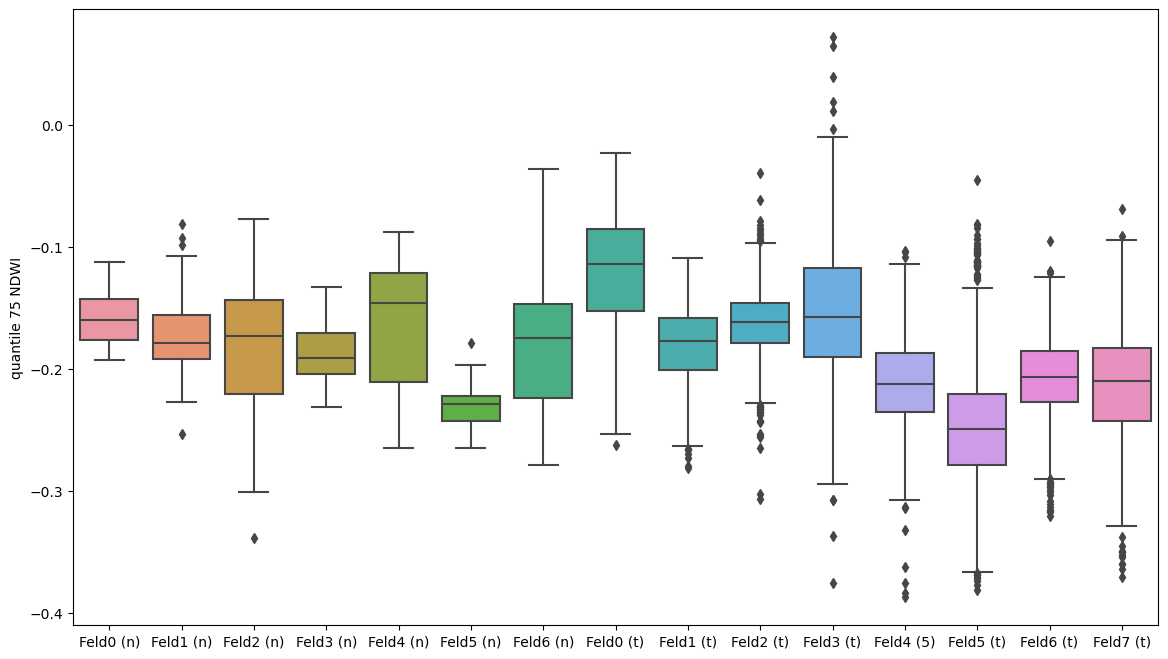

In [41]:
plt.figure(figsize=(14, 8))
sb.boxplot(quantil_75_stau_list+quantil_75_trock_list).set( 
    ylabel='quantile 75 NDWI',
    xticklabels=['Feld0 (n)','Feld1 (n)', 'Feld2 (n)','Feld3 (n)', 'Feld4 (n)','Feld5 (n)', 
                 'Feld6 (n)','Feld0 (t)', 'Feld1 (t)','Feld2 (t)', 'Feld3 (t)','Feld4 (5)', 
                 'Feld5 (t)','Feld6 (t)', 'Feld7 (t)'])


plt.show()

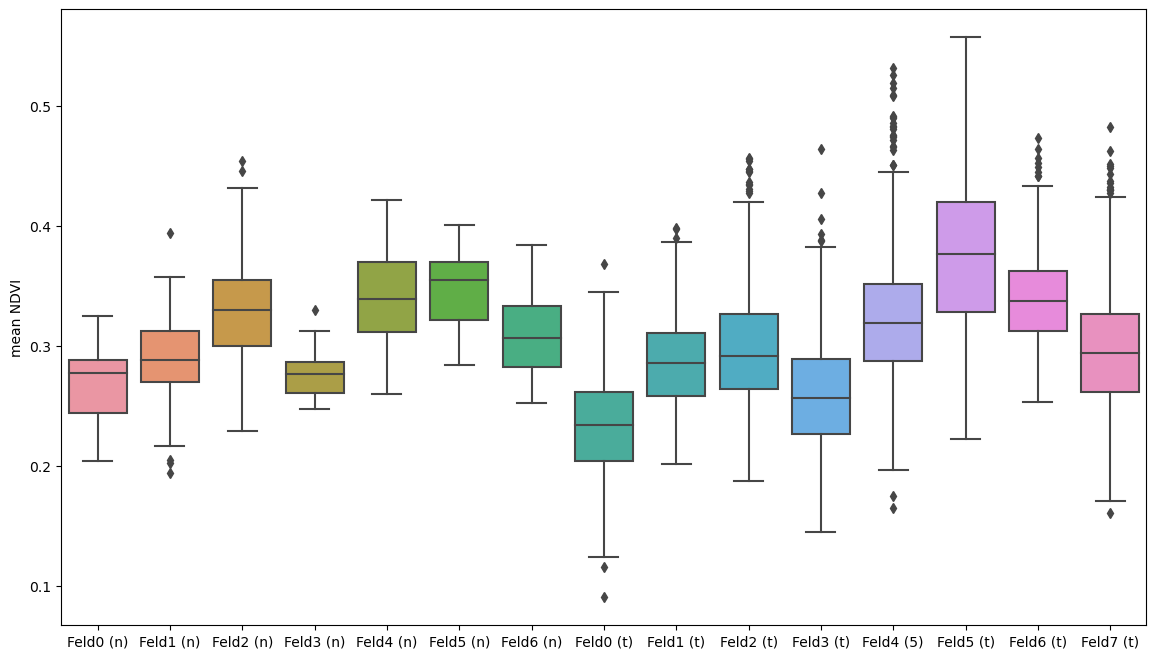

In [42]:
plt.figure(figsize=(14, 8))
sb.boxplot(mean_stau_list_ndvi+mean_trock_list_ndvi).set( 
    ylabel='mean NDVI',
    xticklabels=['Feld0 (n)','Feld1 (n)', 'Feld2 (n)','Feld3 (n)', 'Feld4 (n)','Feld5 (n)', 
                 'Feld6 (n)','Feld0 (t)', 'Feld1 (t)','Feld2 (t)', 'Feld3 (t)','Feld4 (5)', 
                 'Feld5 (t)','Feld6 (t)', 'Feld7 (t)'])


plt.show()

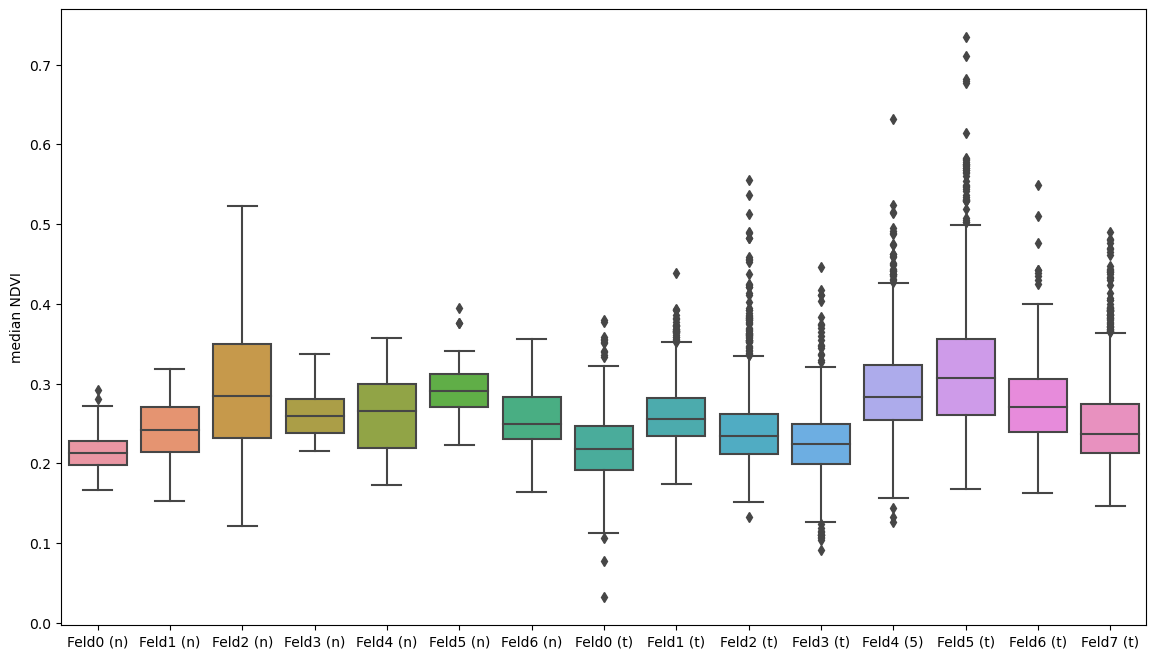

In [43]:
plt.figure(figsize=(14, 8))
sb.boxplot(median_stau_list_ndvi+median_trock_list_ndvi).set( 
    ylabel='median NDVI',
    xticklabels=['Feld0 (n)','Feld1 (n)', 'Feld2 (n)','Feld3 (n)', 'Feld4 (n)','Feld5 (n)', 
                 'Feld6 (n)','Feld0 (t)', 'Feld1 (t)','Feld2 (t)', 'Feld3 (t)','Feld4 (5)', 
                 'Feld5 (t)','Feld6 (t)', 'Feld7 (t)'])


plt.show()

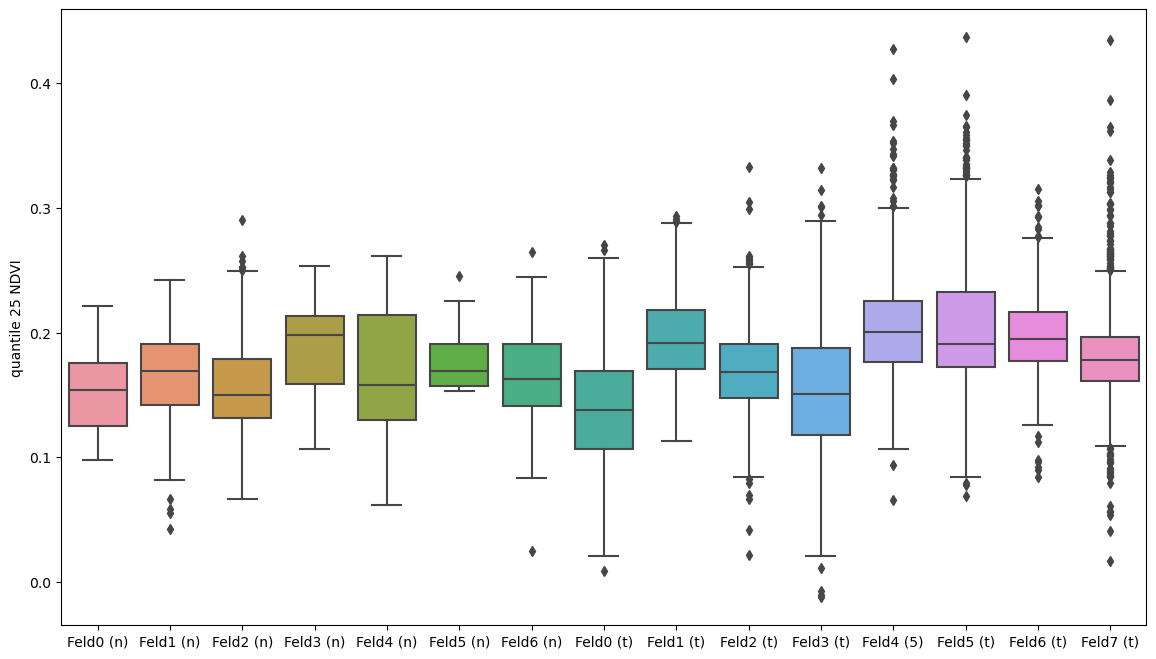

In [44]:
plt.figure(figsize=(14, 8))
sb.boxplot(quantil_25_stau_list_ndvi+quantil_25_trock_list_ndvi).set( 
    ylabel='quantile 25 NDVI',
    xticklabels=['Feld0 (n)','Feld1 (n)', 'Feld2 (n)','Feld3 (n)', 'Feld4 (n)','Feld5 (n)', 
                 'Feld6 (n)','Feld0 (t)', 'Feld1 (t)','Feld2 (t)', 'Feld3 (t)','Feld4 (5)', 
                 'Feld5 (t)','Feld6 (t)', 'Feld7 (t)'])


plt.show()

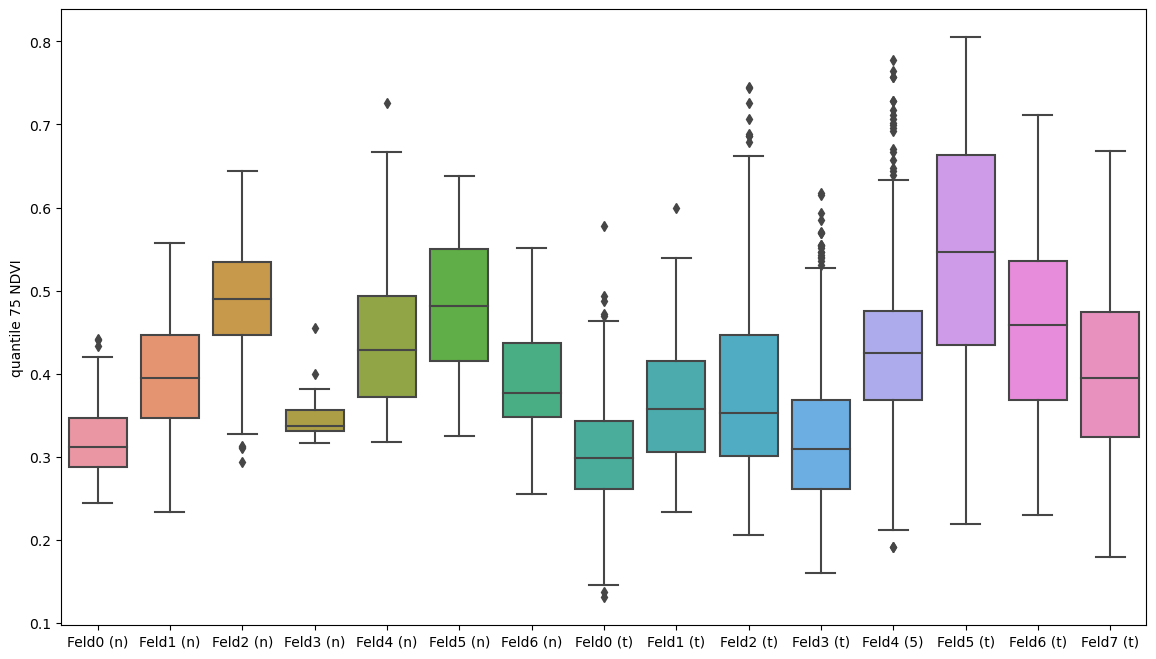

In [45]:
plt.figure(figsize=(14, 8))
sb.boxplot(quantil_75_stau_list_ndvi+quantil_75_trock_list_ndvi).set( 
    ylabel='quantile 75 NDVI',
    xticklabels=['Feld0 (n)','Feld1 (n)', 'Feld2 (n)','Feld3 (n)', 'Feld4 (n)','Feld5 (n)', 
                 'Feld6 (n)','Feld0 (t)', 'Feld1 (t)','Feld2 (t)', 'Feld3 (t)','Feld4 (5)', 
                 'Feld5 (t)','Feld6 (t)', 'Feld7 (t)'])


plt.show()